In [1]:
!pip install transformers

     |████████████████████████████████| 890kB 4.7MB/s 
     |████████████████████████████████| 1.1MB 25.5MB/s 
     |████████████████████████████████| 3.0MB 34.0MB/s 
     |████████████████████████████████| 890kB 55.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bd317b669fbc708278361880c197c3bad84738dd2b409a7a5c63bcdd4900a3e5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# --> for cleaning:
!pip install langdetect

     |████████████████████████████████| 983kB 5.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=250538286ec85b39a4eac42f47d02294a1c5588d42eed845146528f4318391a9
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelWithLMHead
from google.cloud import bigquery
from langdetect import detect
from google.colab import auth,drive
import pandas as pd

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
auth.authenticate_user()

In [6]:
project_id = 'tlac-vision'

client = bigquery.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `tlac-vision.book_backend.train_categories`
''').to_dataframe()

In [7]:
# --> sorting dataframe by book category, from A to Z
df = df.sort_values(['category'], ascending=True)

# --> dropping duplicate rows
df = df.drop_duplicates(['title']).reset_index(drop=True)

In [8]:
# --> deleting results that are in other languages different to spanish
df['language'] = ""
for index, row in df.iterrows():
    row['language'] = detect(row['description'])
df = df[df.language == 'es']

cat_count = df.iloc[:,0:2].groupby('category').count().rename(columns={'title': 'count'})  # total of registers per category

In [9]:
# --> 75% of data is for training
cat_count['training'] = round(0.75 * cat_count['count'], 0)

# --> organizing indexes to split data
cat_count['acum'] = cat_count['count'].cumsum()
cat_count['init_idx'] = cat_count['acum'] - cat_count['count']
cat_count['train_idx'] = cat_count['init_idx'] + cat_count['training']

In [10]:
# --> creating training set with 75% of data per category
train_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 3])
    f_idx = int(cat_count.iloc[i, 4])
    train_set = train_set.append(df.iloc[i_idx:f_idx, :])

train_set_f = train_set.loc[:, ['category', 'description']]
train_set_f=train_set_f.reset_index(drop=True)
#train_set_f['is_valid']=False
train_set_f.iloc[0:5,]

,category,description
0,anthropology,"""Después de 60 años como misionero en el Perú ..."
1,anthropology,A lo largo de los últimos cien años la antropo...
2,anthropology,"En este libro, uno de los principales teoricos..."
3,anthropology,"El fuego, presente ya en los inicios del proce..."
4,anthropology,Este ambicioso tratado sobre el fenómeno relig...


In [11]:
# --> creating validation set with 25% of data per category
val_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 4])
    f_idx = int(cat_count.iloc[i, 2])
    val_set = val_set.append(df.iloc[i_idx:f_idx, :])

val_set_f = val_set.loc[:, ['category', 'description']]
val_set_f=val_set_f.reset_index(drop=True)
#val_set_f['is_valid']=True
val_set_f.iloc[0:5,]

,category,description
0,anthropology,Antología preparada en torno al axolote (o axó...
1,anthropology,Sirviéndose de los recursos metodológicos prop...
2,anthropology,Este trabajo consta de dos partes bien diferen...
3,anthropology,"Los problemas de la bioética no solo son, en l..."
4,anthropology,"La ANTROPOLOGÍA kantiana, más que en la divers..."


In [15]:
id_label = dict(zip(train_set_f['category'].unique(), range(0,11))) #categorical labels to numerical
train_labels,train_text= train_set_f['category'].map(id_label),train_set_f['description']
val_labels,val_text= val_set_f['category'].map(id_label),val_set_f['description']

In [16]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
bert_es = AutoModelWithLMHead.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased") #pretrained model

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Some weights of BertForMaskedLM were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa745486ac8>]],
      dtype=object)

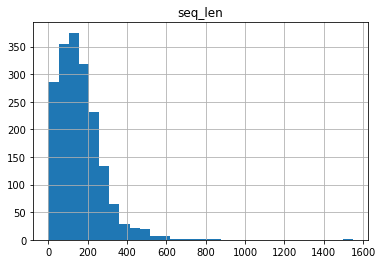

In [17]:
# --> distribution of the sequence lengths(number of words) in the train set to find the padding length 
seq_len = pd.DataFrame([len(i.split()) for i in train_set_f['description']],columns=['seq_len'])
seq_len.hist(bins = 30)

In [18]:
def intervals():
  to_return=list()
  j=0
  for i in range(0,32):
    to_return.append(j)
    j+=50

  return to_return
    
ranges = intervals()

sl_grouped=seq_len.groupby(pd.cut(seq_len.seq_len, ranges)).count().rename(columns={'seq_len':''})
sl_grouped=sl_grouped.add_suffix('count').reset_index()
sl_grouped['%']=round(100*sl_grouped['count'].cumsum()/sl_grouped['count'].sum(),3)

sl_grouped.iloc[0:10,:] 

,seq_len,count,%
0,"(0, 50]",268,14.440
1,"(50, 100]",350,33.297
2,"(100, 150]",358,52.586
3,"(150, 200]",314,69.504
4,"(200, 250]",244,82.651
5,"(250, 300]",149,90.679
6,"(300, 350]",67,94.289
7,"(350, 400]",36,96.228
8,"(400, 450]",22,97.414
9,"(450, 500]",24,98.707


In [19]:
# --> tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

# --> tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

In [20]:
# --> sample data for BETO
text = ["esta es una prueba","estoy haciendo una prueba"]
sent_id = tokenizer.batch_encode_plus(text, padding=True) # encode text
print(sent_id)

{'input_ids': [[4, 1149, 1028, 1091, 3610, 5], [4, 1435, 2194, 1091, 3610, 5]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


In [21]:
# --> convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [22]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# dataLoaders
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [23]:
#  --> freeze all the layers of the model before fine-tuning it

for param in bert_es.parameters():
    param.requires_grad = False

In [26]:
# --> model architecture

class BERT_Arch(torch.nn.Module):

    def __init__(self, bert_es):
      
      super(BERT_Arch, self).__init__()
      self.bert_es = bert_es 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert_es(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x